In [1]:
!pip show scikit-learn torch matplotlib pandas numpy | findstr "Name Version"

Name: scikit-learn
Version: 1.6.1
         Name: Microsoft Visual C++ Runtime Files
Name: torch
Version: 2.6.0
Name: matplotlib
Version: 3.10.1
Name: pandas
Version: 2.2.3
Name: numpy
Version: 2.0.2
        Name: lapack-lite
        Name: dragon4
        Name: libdivide
        Name: Meson
        Name: spin
        Name: OpenBLAS
        Name: LAPACK
        Name: GCC runtime library
        Version 3.1, 31 March 2009
                               Version 3, 29 June 2007
          5. Conveying Modified Source Versions.
          14. Revised Versions of this License.


## 数据预处理

### 加载数据集

In [2]:
from sklearn.metrics import mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import torch
import os

# 自动下载数据集（约50KB）      缓存到了 ~/scikit_learn_data/openml/目录下
boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame

# 查看数据
print(f"特征字段: {boston.feature_names}")
print(f"样本数: {len(df)}")
print(f"特征与标签数: {len(df.columns)}")
df.head()

特征字段: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
样本数: 506
特征与标签数: 14


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


```
数据集  6
  |
  |-- 训练集  5
  |     |-- 训练   4
  |     |
  |     |-- 验证   1
  |
  |-- 测试集  1
```
### 数据划分及标准化

下面两个单元格选一个就行。由于信息量不是很多，感觉还是选第一个好一点

In [3]:
# 加载数据
X = df.drop("MEDV", axis=1)  # 特征数据（拿掉MEDV）
y = df["MEDV"]               # 目标数据

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 6, random_state=42
)
# 进一步划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

scaler = StandardScaler()

# 标准化+拟合
X_train_scaled = scaler.fit_transform(X_train)

# 标准化
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

train_dataset = TensorDataset(
    torch.tensor(X_train_scaled, dtype=torch.float32),
    torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1),
)
val_dataset = TensorDataset(
    torch.tensor(X_val_scaled, dtype=torch.float32),
    torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1),
)
test_dataset = TensorDataset(
    torch.tensor(X_test_scaled, dtype=torch.float32),
    torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1),
)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(
    f"训练样本数: {len(train_dataset)}, 验证样本数: {len(val_dataset)}, 测试样本数: {len(test_dataset)}"
)

训练样本数: 336, 验证样本数: 85, 测试样本数: 85


In [4]:
# 插在加载和划分的中间，其它都一样
# # 加大关键特征RM、CRIM、LSTAT对数据的影响
# X['RM'] *= 2.0
# X['CRIM'] *= 2.0
# X['LSTAT'] *= 2.0

## Model build

#### 前馈神经网络

输入13维，输出一个神经元

使用均方误差（MSE）作为损失函数，优化器默认使用SGD（数据量比较小）

- `hidden_layers`：隐藏层
- `activation`：激活函数
- `learning_rate`：学习率
- `optimizer`: 优化器


In [5]:
class FNN(nn.Module):
    def __init__(self, input_dim=13, hidden_layers=1, activation="relu"):
        super(FNN, self).__init__()
        hl = []
        hl.append(nn.Linear(input_dim, 64)) # 设置太大容易过拟合，数据量太少了，又不能做数据增强
        if activation == "relu":
            activation_fn = nn.ReLU()
        elif activation == "tanh":
            activation_fn = nn.Tanh()
        elif activation == "sigmoid":
            activation_fn = nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation: {activation}")        
        hl.append(activation_fn)
        for _ in range(hidden_layers - 1):  # 隐藏层就是所有层数减去输入输出
            hl.append(nn.Linear(64, 64))
            hl.append(activation_fn)
        hl.append(nn.Linear(64, 1))
        self.model = nn.Sequential(*hl)

    def forward(self, x):
        return self.model(x)

In [6]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, epochs=100, lr=0.001):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.lr = lr

        self.criterion = nn.MSELoss()  # 损失函数
        self.optimizer = optim.SGD(self.model.parameters(), lr=self.lr)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, "min", patience=5)

        self.train_losses = []
        self.val_losses = []

        self.best_val_loss = float("inf")
        self.best_model_path = "best_fnn.pth"

    def train(self):
        for epoch in range(self.epochs):
            # 训练
            train_loss = self.train_part()

            # 验证
            val_loss = self.check_part()

            # 调整学习率
            self.scheduler.step(val_loss)

            # 保存最佳模型
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), self.best_model_path)
                print(f"Best model saved with val_loss: {val_loss:.4f}")

            print(f"Epoch {epoch + 1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return self.train_losses, self.val_losses


    def train_part(self):
        self.model.train()
        total_loss = 0.0
        for X_batch, y_batch in self.train_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            self.optimizer.zero_grad()              # 梯度清零
            y_pred = self.model(X_batch)            # 前向传播
            loss = self.criterion(y_pred, y_batch)  # 计算损失
            loss.backward()                         # 反向传播，计算梯度
            self.optimizer.step()                   # 更新参数

            total_loss += loss.item() * X_batch.size(0)

        avg_loss = total_loss / len(self.train_loader.dataset)
        self.train_losses.append(avg_loss)
        return avg_loss

    def check_part(self):
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in self.val_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_pred = self.model(X_batch)
                loss = self.criterion(y_pred, y_batch)

                total_loss += loss.item() * X_batch.size(0)

        avg_loss = total_loss / len(self.val_loader.dataset)
        self.val_losses.append(avg_loss)
        return avg_loss

`MSE`和`MAE`越小越好，$R^2$越大越好

In [7]:
def evaluate_model(model, test_loader, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    total_loss = 0.0
    y_true = []
    y_pred = []
    criterion = nn.MSELoss()

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    avg_loss = total_loss / len(test_loader.dataset)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return y_true, y_pred, avg_loss, mae, r2

#### 使用保存的模型

In [8]:
def test(param_name, param_values, model_name, plot_name, epochs = 30, lr = 0.001):
    results = {}
    fail = []

    for param_value in param_values:
        if param_name == "hidden_layers":
            model = FNN(hidden_layers=param_value, activation="relu")
        elif param_name == "learning_rate":
            model = FNN(hidden_layers=2, activation="relu")
            lr = param_value
        elif param_name == "activation":
            model = FNN(hidden_layers=2, activation=param_value)
        else:
            raise ValueError(f"Unsupported parameter: {param_name}")

        trainer = ModelTrainer(
            model,
            train_loader,
            val_loader,
            epochs=epochs,
            lr=lr,
        )
        train_losses, val_losses = trainer.train()
        # 检查是否出现梯度爆炸（损失值为 NaN）
        if any([torch.isnan(torch.tensor(loss)) for loss in train_losses]) or any(
            [torch.isnan(torch.tensor(loss)) for loss in val_losses]
        ):
            print(f"Skipping parameter value {param_value} due to NaN in losses.")
            fail.append(param_value)
        results[param_value] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
        }

        old_file_name = "best_fnn.pth"
        new_file_name = f"{model_name}_{param_value}.pth"
        if os.path.exists(old_file_name):
            os.rename(old_file_name, new_file_name)

    # 测试评估
    test_results = {}
    for param_value in param_values:
        if param_name == "hidden_layers":
            model = FNN(input_dim=13, hidden_layers=param_value, activation="relu")
        elif param_name == "learning_rate":
            model = FNN(input_dim=13, hidden_layers=2, activation="relu")
        elif param_name == "activation":
            model = FNN(input_dim=13, hidden_layers=2, activation=param_value)
        else:
            raise ValueError(f"Unsupported parameter: {param_name}")

        if param_value in fail:
            continue
        # 测试评估模型
        y_true, y_pred, avg_loss, mae, r2 = evaluate_model(
            model,
            test_loader,
            f"{model_name}_{param_value}.pth",
        )
        test_results[param_value] = {
            "y_true": y_true,
            "y_pred": y_pred,
            "avg_loss": avg_loss,
            "mae": mae,
            "r2": r2,
        }

    # 绘制训练和验证损失曲线
    plt.figure(figsize=(12, 6))

    # 绘制训练损失曲线
    plt.subplot(1, 3, 1)
    for param_value in results:
        plt.plot(
            results[param_value]["train_losses"], label=f"{plot_name} {param_value}"
        )
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("Train Loss vs Different Configurations")
    plt.legend()

    # 绘制验证损失曲线
    plt.subplot(1, 3, 2)
    for param_value in results:
        plt.plot(results[param_value]["val_losses"], label=f"{plot_name} {param_value}")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Validation Loss vs Different Configurations")
    plt.legend()

    # 绘制测试损失曲线
    plt.subplot(1, 3, 3)

    # 准备横轴和纵轴数据
    x_values = []  # 横轴：有效的 param_values
    y_values = []  # 纵轴：对应的 avg_loss

    for param_value in test_results:
        avg_loss = test_results[param_value]["avg_loss"]
        x_values.append(param_value)  # 添加横轴值
        y_values.append(avg_loss)    # 添加纵轴值

    # 绘制折线图
    plt.plot(
        x_values, y_values, marker="o", label="Test Loss"
    )

    plt.xlabel("Parameter Value")
    plt.ylabel("Test Loss (Avg MSE)")
    plt.title("Test Loss vs Different Configurations")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{plot_name}_loss_comparison.png")
    plt.show()

    # 绘制预测值与真实值的对比图
    plt.figure(figsize=(12, 6))
    for param_value in test_results:
        if param_value in fail:
            continue
        plt.scatter(
            test_results[param_value]["y_true"],
            test_results[param_value]["y_pred"],
            label=f"{plot_name} {param_value}",
            alpha=0.6,
        )
    plt.plot(
        [min(y_true), max(y_true)],
        [min(y_true), max(y_true)],
        color="red",
        linestyle="--",
        label="Ideal Prediction",
    )
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{plot_name}_true_vs_predicted.png")
    plt.show()

    # 输出评估指标
    for param_value in test_results:
        avg_loss = test_results[param_value]["avg_loss"]
        mae = test_results[param_value]["mae"]
        r2 = test_results[param_value]["r2"]
        print(f"{param_name}: {param_value}")
        print(f"MSE: {avg_loss:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R²: {r2:.4f}")
        print("-" * 50)

#### 网络深度

Best model saved with val_loss: 433.1681
Epoch 1/100, Train Loss: 583.4462, Val Loss: 433.1681
Best model saved with val_loss: 303.4271
Epoch 2/100, Train Loss: 469.8035, Val Loss: 303.4271
Best model saved with val_loss: 136.8962
Epoch 3/100, Train Loss: 299.9463, Val Loss: 136.8962
Best model saved with val_loss: 56.2358
Epoch 4/100, Train Loss: 135.9381, Val Loss: 56.2358
Best model saved with val_loss: 32.3784
Epoch 5/100, Train Loss: 70.1827, Val Loss: 32.3784
Best model saved with val_loss: 22.9773
Epoch 6/100, Train Loss: 46.6475, Val Loss: 22.9773
Best model saved with val_loss: 19.9445
Epoch 7/100, Train Loss: 35.8047, Val Loss: 19.9445
Best model saved with val_loss: 18.8814
Epoch 8/100, Train Loss: 31.2589, Val Loss: 18.8814
Best model saved with val_loss: 18.1503
Epoch 9/100, Train Loss: 28.8270, Val Loss: 18.1503
Best model saved with val_loss: 17.8250
Epoch 10/100, Train Loss: 27.3766, Val Loss: 17.8250
Best model saved with val_loss: 17.0056
Epoch 11/100, Train Loss: 26.

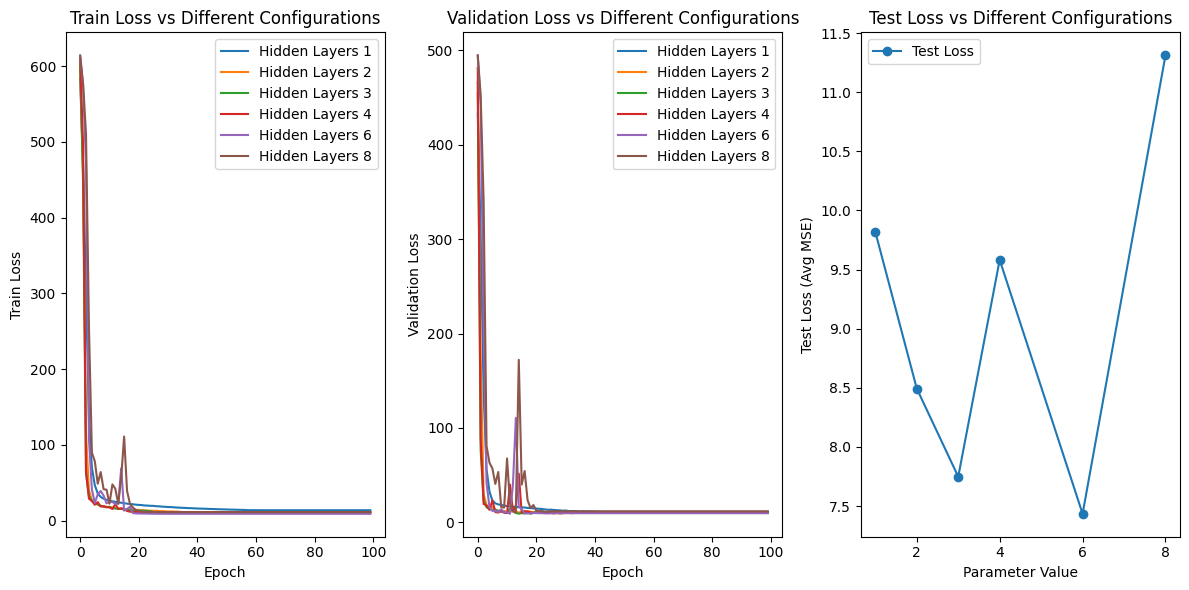

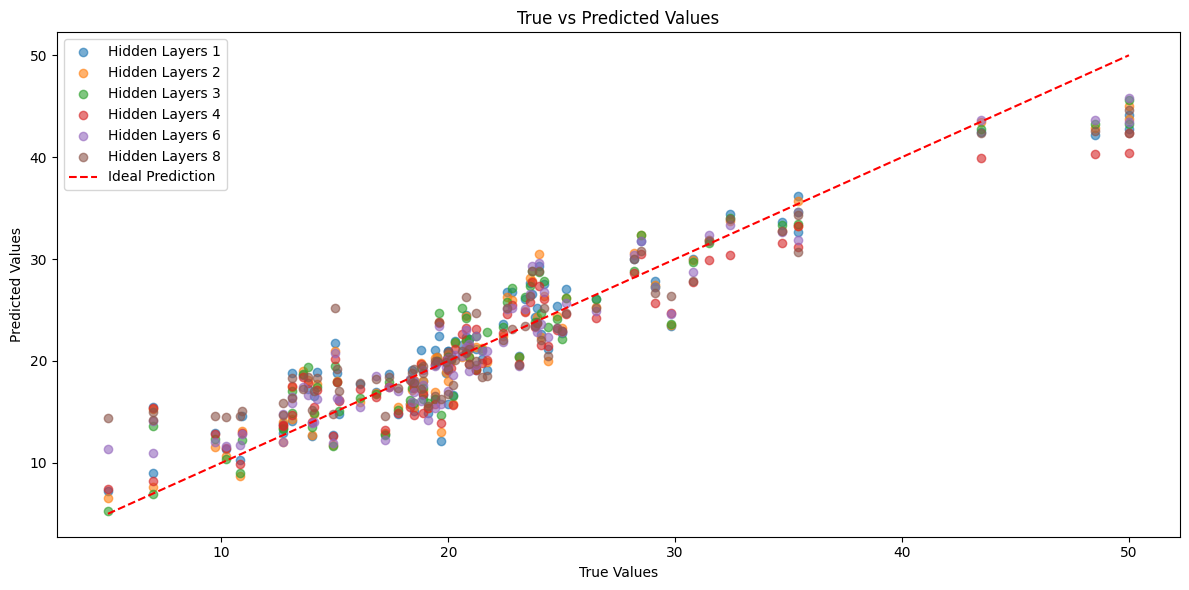

hidden_layers: 1
MSE: 9.8180
MAE: 2.4983
R²: 0.8650
--------------------------------------------------
hidden_layers: 2
MSE: 8.4937
MAE: 2.2117
R²: 0.8832
--------------------------------------------------
hidden_layers: 3
MSE: 7.7485
MAE: 2.1035
R²: 0.8934
--------------------------------------------------
hidden_layers: 4
MSE: 9.5817
MAE: 2.4071
R²: 0.8682
--------------------------------------------------
hidden_layers: 6
MSE: 7.4349
MAE: 2.0960
R²: 0.8977
--------------------------------------------------
hidden_layers: 8
MSE: 11.3122
MAE: 2.5398
R²: 0.8444
--------------------------------------------------


In [9]:
param_name = "hidden_layers"
param_values = [1, 2, 3, 4, 6, 8]
model_name = "FNN_hidden_layers"
plot_name = "Hidden Layers"
test(param_name, param_values, model_name, plot_name, epochs=100)

#### 学习率

Epoch 1/30, Train Loss: nan, Val Loss: nan
Epoch 2/30, Train Loss: nan, Val Loss: nan
Epoch 3/30, Train Loss: nan, Val Loss: nan
Epoch 4/30, Train Loss: nan, Val Loss: nan
Epoch 5/30, Train Loss: nan, Val Loss: nan
Epoch 6/30, Train Loss: nan, Val Loss: nan
Epoch 7/30, Train Loss: nan, Val Loss: nan
Epoch 8/30, Train Loss: nan, Val Loss: nan
Epoch 9/30, Train Loss: nan, Val Loss: nan
Epoch 10/30, Train Loss: nan, Val Loss: nan
Epoch 11/30, Train Loss: nan, Val Loss: nan
Epoch 12/30, Train Loss: nan, Val Loss: nan
Epoch 13/30, Train Loss: nan, Val Loss: nan
Epoch 14/30, Train Loss: nan, Val Loss: nan
Epoch 15/30, Train Loss: nan, Val Loss: nan
Epoch 16/30, Train Loss: nan, Val Loss: nan
Epoch 17/30, Train Loss: nan, Val Loss: nan
Epoch 18/30, Train Loss: nan, Val Loss: nan
Epoch 19/30, Train Loss: nan, Val Loss: nan
Epoch 20/30, Train Loss: nan, Val Loss: nan
Epoch 21/30, Train Loss: nan, Val Loss: nan
Epoch 22/30, Train Loss: nan, Val Loss: nan
Epoch 23/30, Train Loss: nan, Val Loss: n

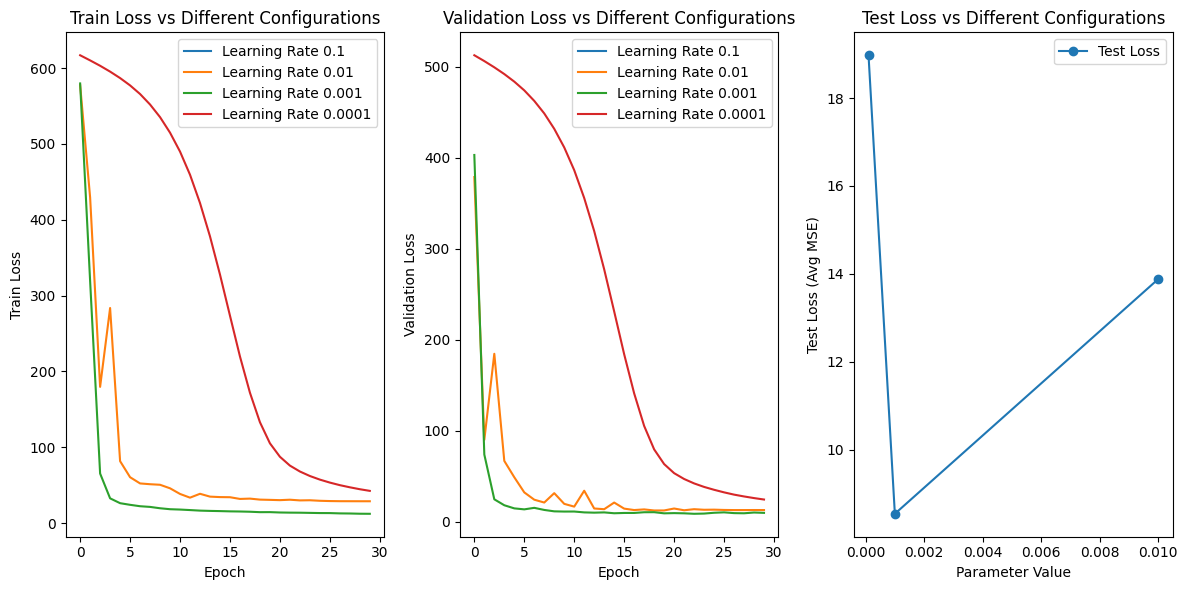

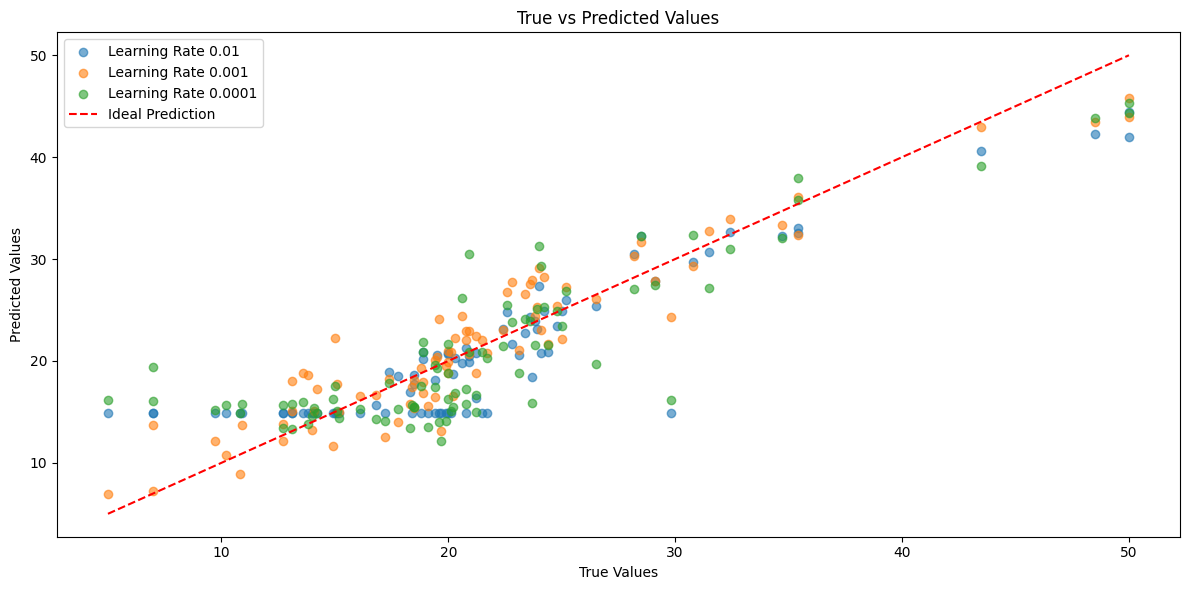

learning_rate: 0.01
MSE: 13.8805
MAE: 2.6618
R²: 0.8091
--------------------------------------------------
learning_rate: 0.001
MSE: 8.5399
MAE: 2.3247
R²: 0.8826
--------------------------------------------------
learning_rate: 0.0001
MSE: 18.9747
MAE: 3.3156
R²: 0.7390
--------------------------------------------------


In [10]:
param_name = "learning_rate"
param_values = [0.1, 0.01, 0.001, 0.0001]    # 学习率太大跑不了（0.1）
model_name = "FNN_learning_rate"
plot_name = "Learning Rate"
test(param_name, param_values, model_name, plot_name)

#### 激活函数

Best model saved with val_loss: 382.4939
Epoch 1/60, Train Loss: 576.4374, Val Loss: 382.4939
Best model saved with val_loss: 47.7217
Epoch 2/60, Train Loss: 276.7522, Val Loss: 47.7217
Best model saved with val_loss: 21.7859
Epoch 3/60, Train Loss: 52.2154, Val Loss: 21.7859
Best model saved with val_loss: 17.5995
Epoch 4/60, Train Loss: 32.1443, Val Loss: 17.5995
Best model saved with val_loss: 15.7463
Epoch 5/60, Train Loss: 26.4197, Val Loss: 15.7463
Epoch 6/60, Train Loss: 23.7775, Val Loss: 16.0474
Best model saved with val_loss: 14.1614
Epoch 7/60, Train Loss: 22.2818, Val Loss: 14.1614
Best model saved with val_loss: 14.0065
Epoch 8/60, Train Loss: 21.1620, Val Loss: 14.0065
Best model saved with val_loss: 13.4069
Epoch 9/60, Train Loss: 19.8494, Val Loss: 13.4069
Best model saved with val_loss: 13.2247
Epoch 10/60, Train Loss: 19.2134, Val Loss: 13.2247
Best model saved with val_loss: 12.1711
Epoch 11/60, Train Loss: 18.4852, Val Loss: 12.1711
Epoch 12/60, Train Loss: 17.9300,

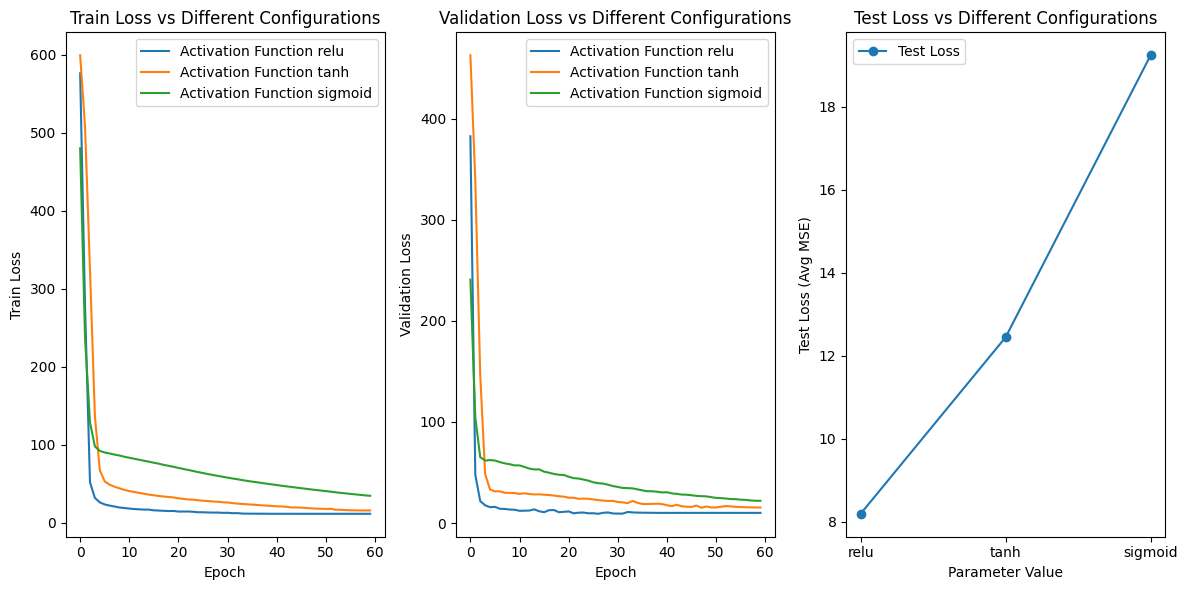

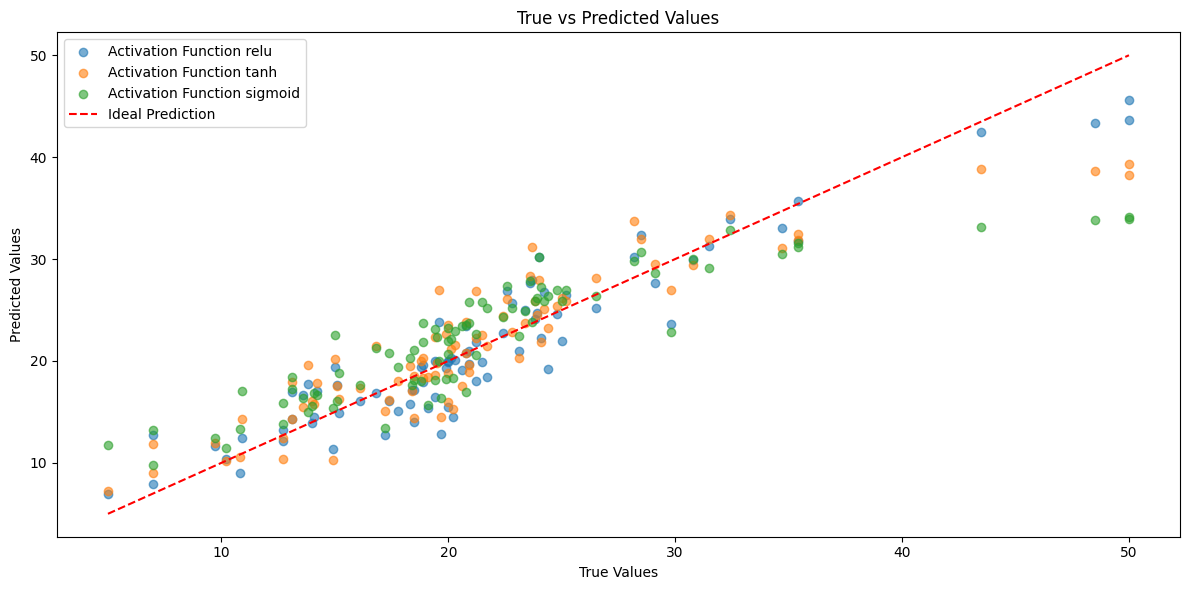

activation: relu
MSE: 8.1871
MAE: 2.1994
R²: 0.8874
--------------------------------------------------
activation: tanh
MSE: 12.4453
MAE: 2.6310
R²: 0.8288
--------------------------------------------------
activation: sigmoid
MSE: 19.2444
MAE: 3.2050
R²: 0.7353
--------------------------------------------------


In [11]:
param_name = "activation"
param_values = ["relu", "tanh", "sigmoid"]
model_name = "FNN_activation"
plot_name = "Activation Function"
test(param_name, param_values, model_name, plot_name, epochs=60)